# Импорт библиотек

In [1]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import xml.etree.ElementTree as et
import cv2
import os
import glob
from tqdm import tqdm
from torchvision.ops import box_iou
from torch import amp


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Загрузка данных в DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')


# путь к файлам
images_dir = '/content/drive/My Drive/Masks/images/'
annotations_dir = '/content/drive/My Drive/Masks/annotations/'


class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width

        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]

        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0

        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]

        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)

            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)


            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[113.1163, 146.7200, 163.7209, 205.5200]]), 'labels': tensor([2]), 'area': tensor([2975.5537]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


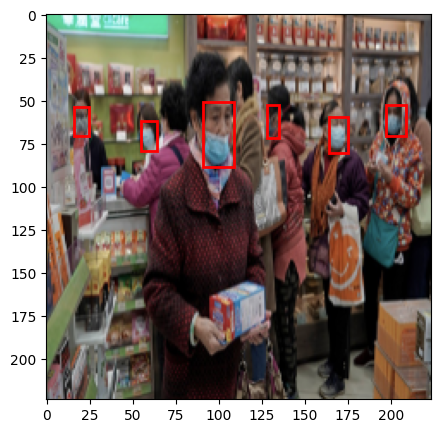

In [3]:
# Вспомогательная функция для визуализации bbox

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        a.add_patch(rect)
    plt.show()

img, target = dataset[35]
plot_img_bbox(img, target)

In [4]:
def get_transform(train):

    if train:
        return A.Compose([
                            #A.HorizontalFlip(0.5),
                            #A.RandomBrightnessContrast(p=0.2),
                            #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [6]:
def get_transform(train):
    if train:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ])
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ])

In [7]:
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            A.RandomBrightnessContrast(p=0.2),
                            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

# Обучение модели

In [11]:
class FaceMaskDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotation_dir, width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width

        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        self.classes = [_, 'without_mask', 'with_mask', 'mask_weared_incorrect']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        img_tensor = torch.from_numpy(img_res).permute(2, 0, 1)  # Изменение порядка осей на (C, H, W)

        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        wt = img.shape[1]
        ht = img.shape[0]

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_corr = (xmin / wt) * self.width
            xmax_corr = (xmax / wt) * self.width
            ymin_corr = (ymin / ht) * self.height
            ymax_corr = (ymax / ht) * self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image=img_tensor, bboxes=target['boxes'], labels=labels)
            img_tensor = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_tensor, target

    def __len__(self):
        return len(self.imgs)

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

if __name__ == "__main__":
    # Путь к директориям с изображениями и аннотациями
    images_dir = '/content/drive/My Drive/Masks/images/'
    annotations_dir = '/content/drive/My Drive/Masks/annotations/'

    # Создание экземпляров датасетов
    dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480)
    dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480)

    # Разделение данных на train и test
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()
    test_split = 0.2
    tsize = int(len(dataset) * test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=10, shuffle=True, num_workers=0,
        collate_fn=collate_fn
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=10, shuffle=False, num_workers=0,
        collate_fn=collate_fn
    )

    # Установка устройства
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    num_classes = 4  # Число классов
    model = get_model_instance_segmentation(num_classes)
    model.to(device)

    num_epochs = 5  # Количество эпох
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for imgs, annotations in data_loader:
            imgs = list(img.to(device) for img in imgs)  # Переносим тензоры на устройство
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print("Training complete!")

Epoch 1/5, Loss: 35.6441
Epoch 2/5, Loss: 22.3093
Epoch 3/5, Loss: 18.2996
Epoch 4/5, Loss: 16.3319
Epoch 5/5, Loss: 14.6894
Training complete!


Причины изменений:

    Преобразование в тензоры:
        Изображения должны быть представлены в формате тензоров PyTorch, чтобы их можно было использовать в модели. Изначально, в нашем коде, изображения загружались как массивы NumPy. Для работы с моделью эти массивы нужно было преобразовать в тензоры.

    Обработка ошибок:
        Изменения включают обработку случаев, когда изображения или аннотации не загружаются корректно. Это помогает избежать неожиданного поведения и позволяет легче диагностировать проблемы при отладке.

    Упрощение кода:
        Некоторые части кода были упрощены для лучшей читаемости и поддержки. Это может помочь в дальнейшем при внесении изменений или расширении функционала.

Итог:

Хотя наш изначальный код мог работать, изменения помогли сделать его более надежным и совместимым с ожидаемым форматом данных для PyTorch. В конечном счете, это улучшает стабильность и предсказуемость работы вашего проекта.

# Сохраним модель

In [12]:
torch.save(model.state_dict(), 'model_face_mask.pth')
print("Модель успешно сохранена!")

Модель успешно сохранена!


In [13]:
# вспомогательная функция принимает исходный прогноз и порог iou

def apply_nms(orig_prediction, iou_thresh=0.3):

    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

predicted #boxes:  1
real #boxes:  1
MODEL OUTPUT


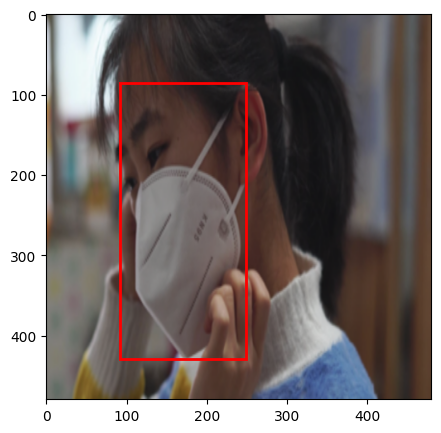

NMS APPLIED MODEL OUTPUT


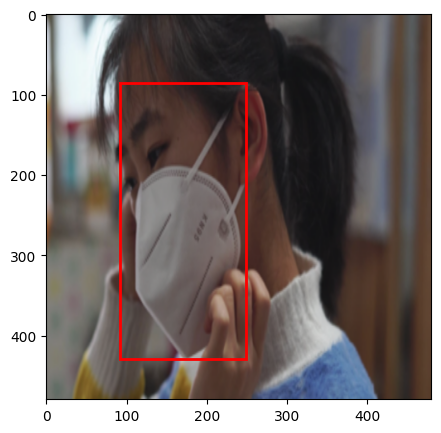

In [14]:
# Получаем изображение и целевое значение из тестового набора
img, target = dataset_test[4]

# Переводим модель в режим оценки
model.eval()
with torch.no_grad():
    # Получаем предсказания модели
    prediction = model([img.to(device)])[0]

# Применяем NMS к предсказаниям
nms_prediction = apply_nms(prediction, iou_thresh=0.3)

# Визуализация предсказаний модели
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

# Переносим изображение на CPU
img_cpu = img.cpu()
img_pil = torch_to_pil(img_cpu)  # Преобразуем тензор в PIL Image

# Убедитесь, что предсказания тоже на CPU
prediction_cpu = {k: v.cpu() for k, v in prediction.items()}

# Визуализация предсказаний модели
print('MODEL OUTPUT')
plot_img_bbox(img_pil, prediction_cpu)

# Визуализация с применением NMS
nms_prediction_cpu = {k: v.cpu() for k, v in nms_prediction.items()}
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(img_pil, nms_prediction_cpu)

EXPECTED OUTPUT


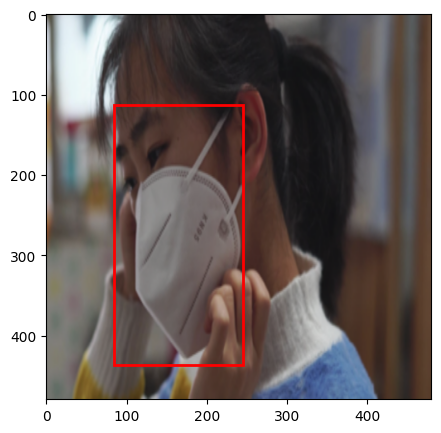

In [15]:
# Получаем изображение и целевое значение из тестового набора
img, target = dataset_test[4]

# Визуализация ожидаемых аннотаций
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img.cpu()), target)

# Отрисовка изображений

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image(img_tensor, annotation, predict=True):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    img = img_tensor.cpu().data
    mask_dic = {1: 'without_mask', 2: 'with_mask', 3: 'mask_weared_incorrect'}

    ax.imshow(img.permute(1, 2, 0))

    for i, box in enumerate(annotation["boxes"]):
        # Используем detach(), чтобы избежать ошибки
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()

        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                 linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)
        label = mask_dic[int(annotation['labels'][i].data)]
        if predict:
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center',
                    verticalalignment='center', fontsize=20, color='b')
        else:
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center',
                    verticalalignment='center', fontsize=20, color='b')
    plt.show()

In [17]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [18]:
model.eval()
preds = model(imgs)

Prediction


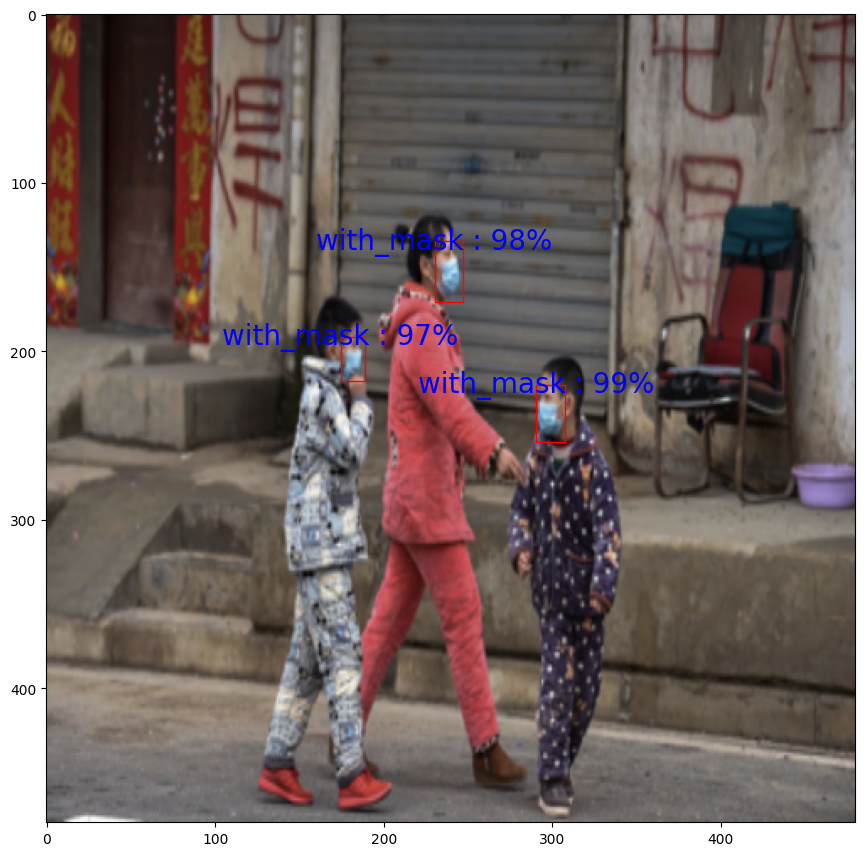

Target


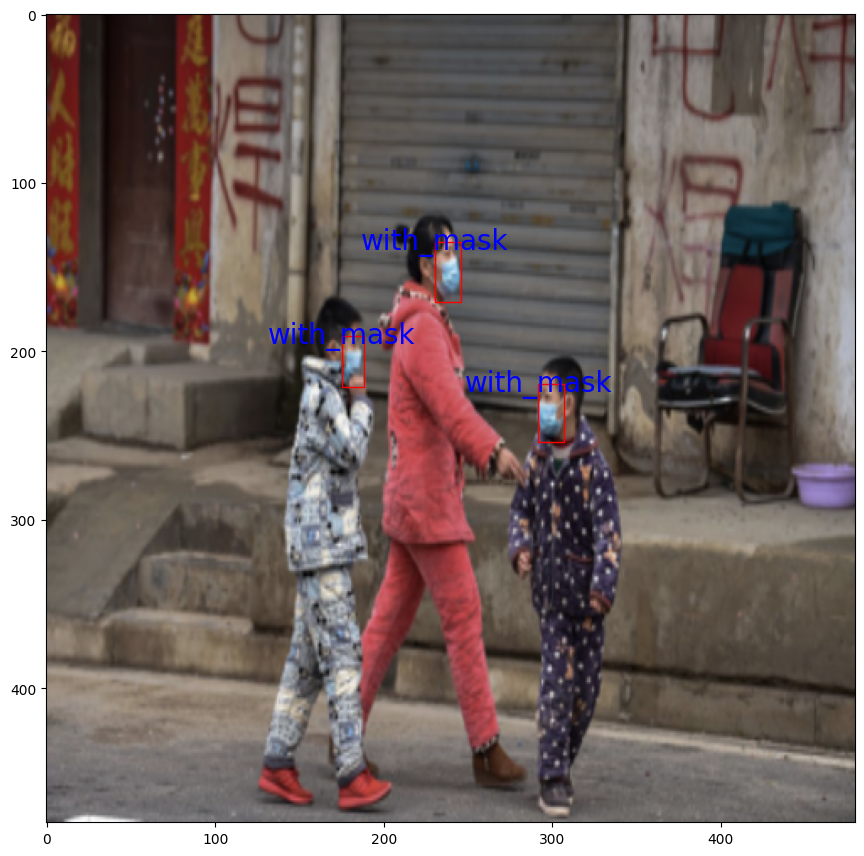

In [19]:
nms_prediction = apply_nms(preds[7], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[7], nms_prediction)
print("Target")
plot_image(imgs[7].to('cpu'), annotations[7],False)

Prediction


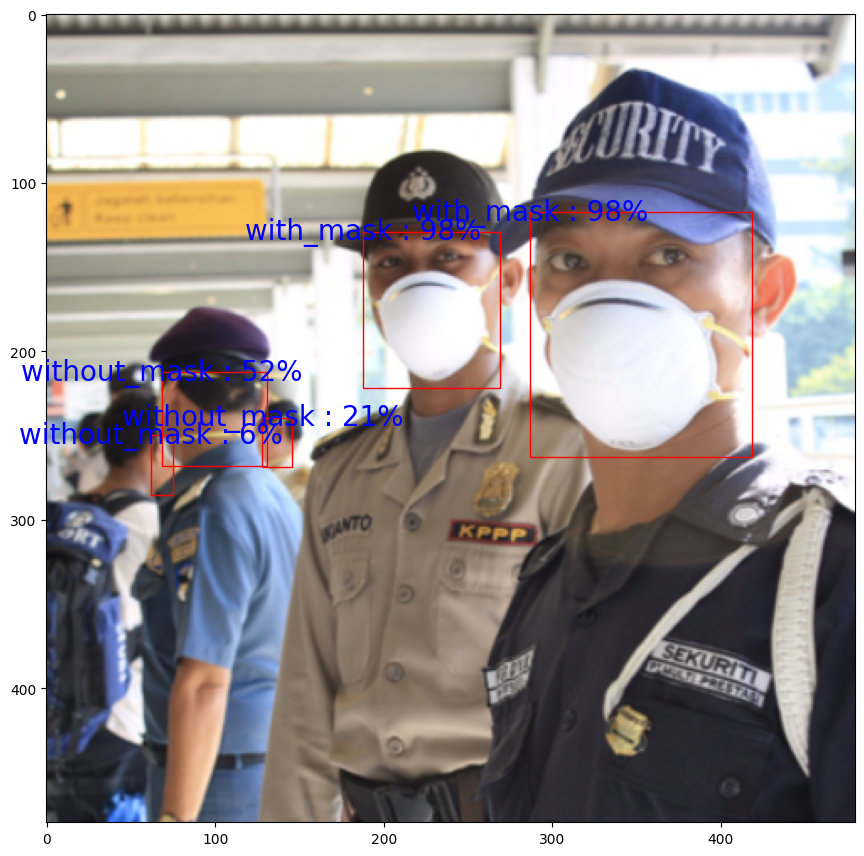

Target


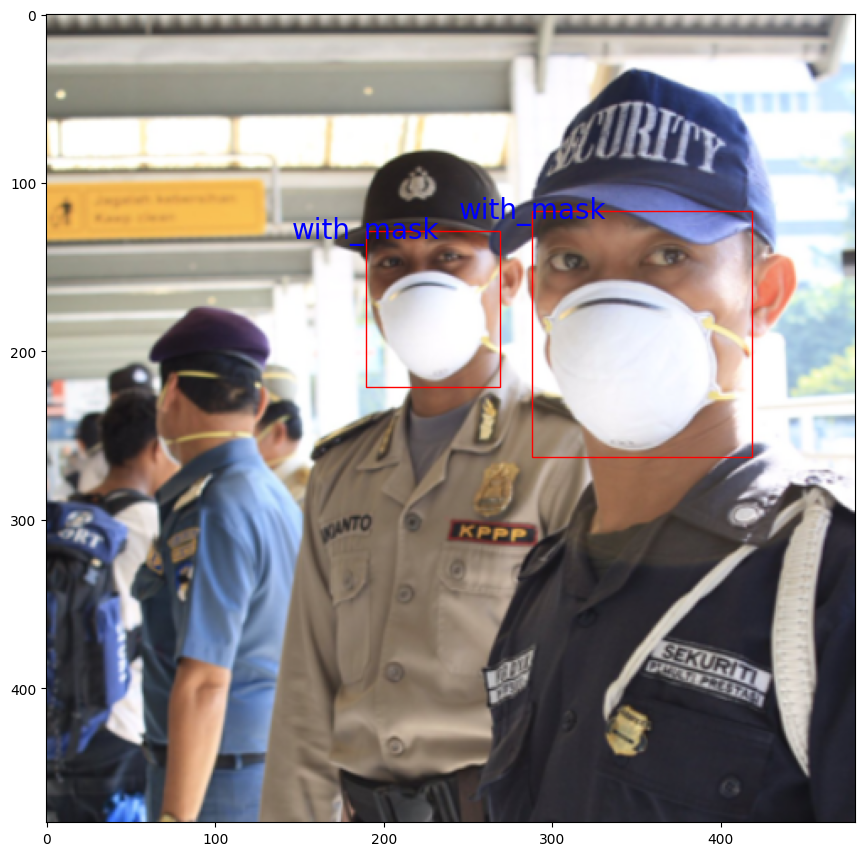

In [20]:
nms_prediction = apply_nms(preds[0], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[0], nms_prediction)
print("Target")
plot_image(imgs[0].to('cpu'), annotations[0],False)

Prediction


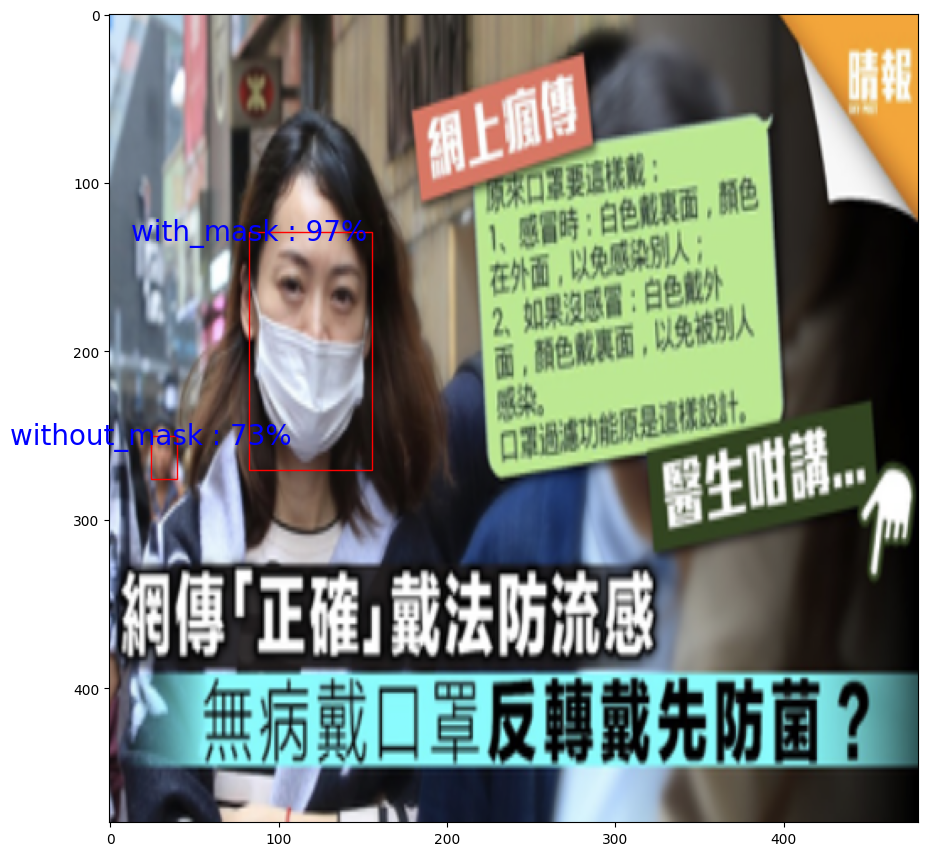

Target


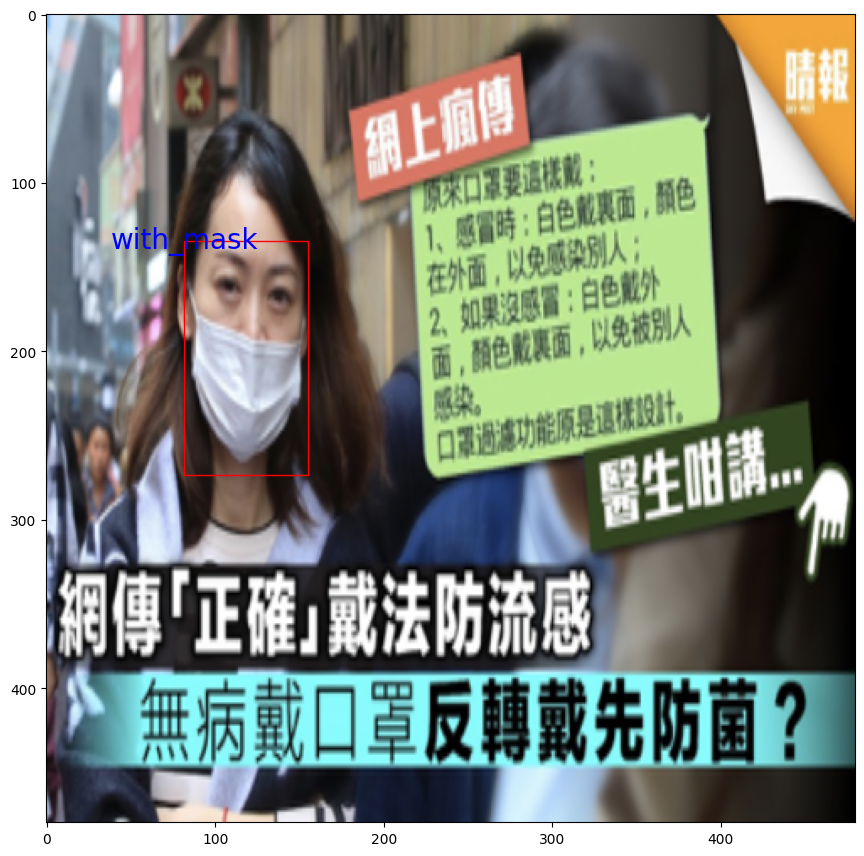

In [21]:
nms_prediction = apply_nms(preds[2], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[2], nms_prediction)
print("Target")
plot_image(imgs[2].to('cpu'), annotations[2],False)

# Расчёт AP/mAP и сохранение значений лосса и метрик

In [22]:
from torchvision.ops import box_iou

def compute_ap(pred_boxes, pred_scores, true_boxes, iou_thresh=0.5):
    # Приводим к правильному формату
    pred_boxes = pred_boxes.cpu().numpy()
    true_boxes = true_boxes.cpu().numpy()

    # Расчёт IoU
    iou = box_iou(torch.tensor(pred_boxes), torch.tensor(true_boxes)).numpy()

    # Считаем, сколько истинных положительных
    true_positives = (iou > iou_thresh).sum(axis=1) > 0
    num_true_positive = true_positives.sum()

    # AP = TP / (TP + FP)
    precision = num_true_positive / (len(pred_boxes) + 1e-6)
    return precision

In [23]:
# Устанавливаем количество эпох и уменьшаем размер батча для снижения нагрузки на память
num_epochs = 5
batch_size = 1  # Уменьшенный размер батча

# Ограничиваем количество батчей для ускорения отладки (например, 20 батчей на эпоху)
num_batches = 16

# Объявляем списки для хранения значений лосса и метрик
loss_values = []
ap_values = []

# Функция для расчета AP
def compute_ap(pred_boxes, pred_scores, true_boxes, iou_thresh=0.5):
    pred_boxes = pred_boxes.cpu().numpy()
    true_boxes = true_boxes.cpu().numpy()

    iou = box_iou(torch.tensor(pred_boxes), torch.tensor(true_boxes)).numpy()
    true_positives = (iou > iou_thresh).sum(axis=1) > 0
    num_true_positive = true_positives.sum()
    precision = num_true_positive / (len(pred_boxes) + 1e-6)
    return precision

scaler = amp.GradScaler()  # Используем смешанную точность
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for i, (imgs, annotations) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        if i >= num_batches:
            break

        imgs = [img.to(device) for img in imgs]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        with amp.autocast(device_type='cuda'):
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()

        if i % 10 == 0:
            print(f"Batch {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

        # Очищаем память
        del imgs, annotations, loss_dict
        torch.cuda.empty_cache()

    loss_values.append(epoch_loss)

    # Рассчёт AP на валидации
    model.eval()
    with torch.no_grad():
        for j, (imgs, annotations) in enumerate(data_loader):
            if j >= num_batches:
                break
            imgs = [img.to(device) for img in imgs]
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            preds = model(imgs)

            for pred, target in zip(preds, annotations):
                ap = compute_ap(pred['boxes'], pred['scores'], target['boxes'])
                ap_values.append(ap)

            del imgs, annotations, preds
            torch.cuda.empty_cache()

    avg_ap = np.mean(ap_values)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Average AP: {avg_ap:.4f}")

Epoch 1/5:   1%|▏         | 1/69 [00:01<01:30,  1.33s/it]

Batch 0/69, Loss: 0.2026


Epoch 1/5:  16%|█▌        | 11/69 [00:15<01:14,  1.28s/it]

Batch 10/69, Loss: 0.1618


Epoch 1/5:  23%|██▎       | 16/69 [00:21<01:12,  1.36s/it]


Epoch 1/5, Loss: 2.9277, Average AP: 0.8153


Epoch 2/5:   1%|▏         | 1/69 [00:01<01:28,  1.30s/it]

Batch 0/69, Loss: 0.1966


Epoch 2/5:  16%|█▌        | 11/69 [00:14<01:14,  1.28s/it]

Batch 10/69, Loss: 0.2031


Epoch 2/5:  23%|██▎       | 16/69 [00:21<01:09,  1.32s/it]


Epoch 2/5, Loss: 2.7317, Average AP: 0.8218


Epoch 3/5:   1%|▏         | 1/69 [00:01<01:21,  1.20s/it]

Batch 0/69, Loss: 0.0923


Epoch 3/5:  16%|█▌        | 11/69 [00:13<01:12,  1.26s/it]

Batch 10/69, Loss: 0.1552


Epoch 3/5:  23%|██▎       | 16/69 [00:20<01:07,  1.28s/it]


Epoch 3/5, Loss: 3.2023, Average AP: 0.8028


Epoch 4/5:   1%|▏         | 1/69 [00:01<01:26,  1.27s/it]

Batch 0/69, Loss: 0.2168


Epoch 4/5:  16%|█▌        | 11/69 [00:14<01:14,  1.29s/it]

Batch 10/69, Loss: 0.3684


Epoch 4/5:  23%|██▎       | 16/69 [00:20<01:09,  1.31s/it]


Epoch 4/5, Loss: 3.1384, Average AP: 0.7975


Epoch 5/5:   1%|▏         | 1/69 [00:01<01:27,  1.29s/it]

Batch 0/69, Loss: 0.2305


Epoch 5/5:  16%|█▌        | 11/69 [00:14<01:14,  1.28s/it]

Batch 10/69, Loss: 0.1444


Epoch 5/5:  23%|██▎       | 16/69 [00:20<01:08,  1.29s/it]


Epoch 5/5, Loss: 2.6344, Average AP: 0.7945


Судя по нашему выводу, обучение модели прошло успешно по всем пяти эпохам. Вот краткий обзор результатов:

    Epoch 1: Loss: 2.9277, Average AP: 0.8153
    Epoch 2: Loss: 2.7317, Average AP: 0.8218
    Epoch 3: Loss: 3.2023, Average AP: 0.8028
    Epoch 4: Loss: 3.1384, Average AP: 0.7975
    Epoch 5: Loss: 2.6344, Average AP: 0.7945

Анализ результатов:

    Потеря (Loss): Потеря во время обучения в целом колебалась, что может указывать на то, что модель обучается, но может быть полезно посмотреть на конкретные батчи для понимания, где возникают проблемы.
    Average AP (Средний AP): Средний AP варьировался, с наивысшим значением 0.8218 на второй эпохе. Это хороший знак, однако стоит отметить, что на третьей и четвертой эпохах значение AP снизилось.

Создадим дополнительные эпохи: Обучение на большем количестве эпох может помочь улучшить стабильность модели, особенно если мы наблюдаем колебания в значениях AP.

In [25]:
# Устанавливаем количество эпох и уменьшаем размер батча для снижения нагрузки на память
num_epochs = 10
batch_size = 1  # Уменьшенный размер батча

# Ограничиваем количество батчей для ускорения отладки (например, 20 батчей на эпоху)
num_batches = 16

# Объявляем списки для хранения значений лосса и метрик
loss_values = []
ap_values = []

# Функция для расчета AP
def compute_ap(pred_boxes, pred_scores, true_boxes, iou_thresh=0.5):
    pred_boxes = pred_boxes.cpu().numpy()
    true_boxes = true_boxes.cpu().numpy()

    iou = box_iou(torch.tensor(pred_boxes), torch.tensor(true_boxes)).numpy()
    true_positives = (iou > iou_thresh).sum(axis=1) > 0
    num_true_positive = true_positives.sum()
    precision = num_true_positive / (len(pred_boxes) + 1e-6)
    return precision

scaler = amp.GradScaler()  # Используем смешанную точность
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for i, (imgs, annotations) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        if i >= num_batches:
            break

        imgs = [img.to(device) for img in imgs]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        with amp.autocast(device_type='cuda'):
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()

        if i % 10 == 0:
            print(f"Batch {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

        # Очищаем память
        del imgs, annotations, loss_dict
        torch.cuda.empty_cache()

    loss_values.append(epoch_loss)

    # Рассчёт AP на валидации
    model.eval()
    with torch.no_grad():
        for j, (imgs, annotations) in enumerate(data_loader):
            if j >= num_batches:
                break
            imgs = [img.to(device) for img in imgs]
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            preds = model(imgs)

            for pred, target in zip(preds, annotations):
                ap = compute_ap(pred['boxes'], pred['scores'], target['boxes'])
                ap_values.append(ap)

            del imgs, annotations, preds
            torch.cuda.empty_cache()

    avg_ap = np.mean(ap_values)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Average AP: {avg_ap:.4f}")

Epoch 1/10:   1%|▏         | 1/69 [00:01<01:26,  1.27s/it]

Batch 0/69, Loss: 0.1736


Epoch 1/10:  16%|█▌        | 11/69 [00:13<01:12,  1.25s/it]

Batch 10/69, Loss: 0.1801


Epoch 1/10:  23%|██▎       | 16/69 [00:20<01:07,  1.28s/it]


Epoch 1/10, Loss: 2.6062, Average AP: 0.7730


Epoch 2/10:   1%|▏         | 1/69 [00:01<01:28,  1.31s/it]

Batch 0/69, Loss: 0.2470


Epoch 2/10:  16%|█▌        | 11/69 [00:14<01:24,  1.45s/it]

Batch 10/69, Loss: 0.1238


Epoch 2/10:  23%|██▎       | 16/69 [00:21<01:12,  1.36s/it]


Epoch 2/10, Loss: 2.8585, Average AP: 0.8198


Epoch 3/10:   1%|▏         | 1/69 [00:01<01:24,  1.25s/it]

Batch 0/69, Loss: 0.1481


Epoch 3/10:  16%|█▌        | 11/69 [00:13<01:12,  1.25s/it]

Batch 10/69, Loss: 0.1040


Epoch 3/10:  23%|██▎       | 16/69 [00:20<01:08,  1.29s/it]


Epoch 3/10, Loss: 2.6247, Average AP: 0.8166


Epoch 4/10:   1%|▏         | 1/69 [00:01<01:25,  1.26s/it]

Batch 0/69, Loss: 0.1957


Epoch 4/10:  16%|█▌        | 11/69 [00:14<01:15,  1.30s/it]

Batch 10/69, Loss: 0.1980


Epoch 4/10:  23%|██▎       | 16/69 [00:20<01:08,  1.30s/it]


Epoch 4/10, Loss: 2.4813, Average AP: 0.8320


Epoch 5/10:   1%|▏         | 1/69 [00:01<01:25,  1.26s/it]

Batch 0/69, Loss: 0.1871


Epoch 5/10:  16%|█▌        | 11/69 [00:14<01:15,  1.29s/it]

Batch 10/69, Loss: 0.1078


Epoch 5/10:  23%|██▎       | 16/69 [00:20<01:07,  1.28s/it]


Epoch 5/10, Loss: 2.5454, Average AP: 0.8372


Epoch 6/10:   1%|▏         | 1/69 [00:01<01:30,  1.33s/it]

Batch 0/69, Loss: 0.1480


Epoch 6/10:  16%|█▌        | 11/69 [00:14<01:16,  1.31s/it]

Batch 10/69, Loss: 0.1321


Epoch 6/10:  23%|██▎       | 16/69 [00:20<01:09,  1.31s/it]


Epoch 6/10, Loss: 2.6840, Average AP: 0.8412


Epoch 7/10:   1%|▏         | 1/69 [00:01<01:29,  1.32s/it]

Batch 0/69, Loss: 0.1422


Epoch 7/10:  16%|█▌        | 11/69 [00:14<01:13,  1.26s/it]

Batch 10/69, Loss: 0.1627


Epoch 7/10:  23%|██▎       | 16/69 [00:20<01:08,  1.29s/it]


Epoch 7/10, Loss: 2.5832, Average AP: 0.8451


Epoch 8/10:   1%|▏         | 1/69 [00:01<01:25,  1.26s/it]

Batch 0/69, Loss: 0.1180


Epoch 8/10:  16%|█▌        | 11/69 [00:14<01:13,  1.26s/it]

Batch 10/69, Loss: 0.1017


Epoch 8/10:  23%|██▎       | 16/69 [00:20<01:08,  1.30s/it]


Epoch 8/10, Loss: 2.2035, Average AP: 0.8402


Epoch 9/10:   1%|▏         | 1/69 [00:01<01:24,  1.24s/it]

Batch 0/69, Loss: 0.1825


Epoch 9/10:  16%|█▌        | 11/69 [00:14<01:13,  1.27s/it]

Batch 10/69, Loss: 0.2019


Epoch 9/10:  23%|██▎       | 16/69 [00:20<01:08,  1.29s/it]


Epoch 9/10, Loss: 1.9418, Average AP: 0.8411


Epoch 10/10:   1%|▏         | 1/69 [00:01<01:27,  1.28s/it]

Batch 0/69, Loss: 0.0992


Epoch 10/10:  16%|█▌        | 11/69 [00:14<01:14,  1.29s/it]

Batch 10/69, Loss: 0.1146


Epoch 10/10:  23%|██▎       | 16/69 [00:20<01:09,  1.30s/it]


Epoch 10/10, Loss: 2.1515, Average AP: 0.8395


# Визуализация

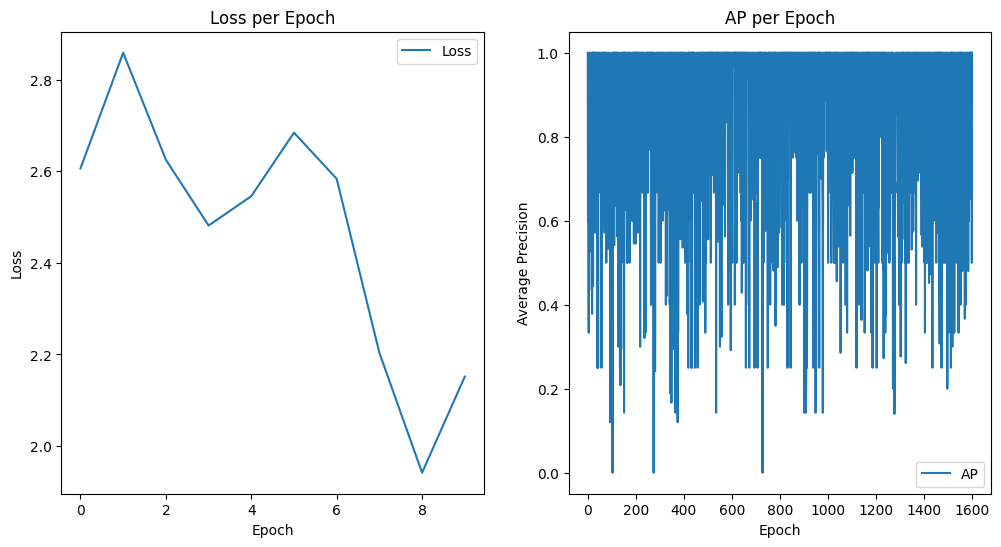

In [26]:
# Визуализация графиков
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ap_values, label='AP')
plt.xlabel('Epoch')
plt.ylabel('Average Precision')
plt.title('AP per Epoch')
plt.legend()

plt.show()

На основе вывода обучения нашей модели можно сделать несколько наблюдений и выводов:

    Снижение потерь:
        Потери (Loss) в большинстве эпох постепенно уменьшаются, что является хорошим знаком, указывающим на то, что модель обучается. Например, начальные потери в первой эпохе составили 2.6062, а в последней – 2.1515.

    Стабильность значений AP:
        Значения Average Precision (AP) колеблются, но в целом остаются на довольно высоком уровне. AP в первой эпохе был 0.7730, достигнув 0.8451 в седьмой эпохе, а затем немного снизившись к 0.8395 в последней эпохе. Это может указывать на то, что модель достигает плато, и дальнейшее обучение может не привести к значительным улучшениям.

    Колебания значений потерь и AP:
        Некоторые эпохи, такие как третья и шестая, показывают увеличение потерь (например, потери в третьей эпохе были 2.6247, а в шестой — 2.6840), что может указывать на то, что модель иногда может «путаться» на определенных наборах данных. В этом случае стоит подумать о добавлении регуляризации или других методов улучшения стабильности.

    Обучение на большем количестве эпох:
        Обучение на 10 эпохах дало достаточно информации о поведении модели. Возможно, стоит увеличить количество эпох еще больше, если есть ресурсы, и продолжить следить за поведением потерь и AP. Вы можете наблюдать, продолжают ли потери снижаться и растет ли AP. Если они начинают ухудшаться или останавливаться, это может быть признаком переобучения.

    Анализ графиков потерь и AP:
        Построение графиков потерь и значений AP поможет визуально оценить стабильность и эффективность обучения. Если график потерь будет демонстрировать тренд к снижению и график AP показывать увеличение, это будет указывать на успешное обучение.
